### Nika Mosayebi Behrooz &emsp; 810196562 &emsp; CA5

In this project, we are using neural networks for image classification. We have a folder containing categorized products. We use this samples to train the network. Then we can predict an image category using the trained neural network.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip -q ./drive/My\ Drive/categorized_products.zip

In [3]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from datetime import timedelta
from datetime import datetime

In [4]:
class CustomToTensor(object):
    """Convert PIL Images in sample to pytorch Tensors."""
    
    ## the input image must be grayscaled first
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        # numpy image: H x W
        return torch.from_numpy(image)

In [5]:
def get_images_indices_per_class(loader, classes):
  images_indices_per_class = {classes[i] : [] for i in range(len(classes))}
  for i, (images, labels) in enumerate(loader, 0):
    for label in labels:
      images_indices_per_class[classes[label]] += [i]
  return images_indices_per_class

In [6]:
def imshow(img_array, classes):
    figure, axs = plt.subplots(2, 6, figsize = (15, 8)) 
    for i in range(2):
      for j in range(6):
        axs[i][j].imshow(img_array[i * 6 + j], cmap='gray')
        axs[i][j].set_title(classes[i * 6 + j])
        axs[i][j].axis('off')
    plt.show()

In [7]:
def get_number_distribution(images_indices_per_class):
  total_category_count = {}
  for c in images_indices_per_class:
    total_category_count[c] = len(images_indices_per_class[c])
  return total_category_count

In [8]:
def study_dataset(dataset_folder):
  transform = transforms.Compose([transforms.Grayscale(),
                                CustomToTensor()
                               ]
                              ) ## composes multiple transforms into single one

  dataset = ImageFolder(dataset_folder, transform=transform)
  print("Number of images: ", len(dataset))
  classes = dataset.classes
  print("Number of classes: ", len(classes))
  print()
  all_loader = torch.utils.data.DataLoader(dataset)
  
  images_indices_per_class = get_images_indices_per_class(all_loader, classes)

  images = []
  i = 0
  for c in images_indices_per_class:
    if i < 12:
      images.append(dataset[images_indices_per_class[c][0]])
      i += 1
    else:
      break

  images_loader = torch.utils.data.DataLoader(images, batch_size = 12)
  data_iter = iter(images_loader)
  new_images, labels = data_iter.next()
  imshow(new_images[0:12], classes[0:12])
  print()

  total_category_count = get_number_distribution(images_indices_per_class)
  counts = []
  for c in images_indices_per_class:
    counts.append(total_category_count[c])
    # print('%s : %d' % (c, total_category_count[c]))

  df = pd.DataFrame({"Class": classes, "Count": counts})
  df_sorted= df.sort_values('Count', ascending = False)
  plt.figure(figsize=(15,8))
  plt.bar('Class', 'Count', data = df_sorted, width = 0.6)
  plt.xlabel("Class", size = 12)
  plt.xticks(rotation = 90)
  plt.ylabel("Count", size = 12)
  plt.title("Distribution in Descending Order", size = 16)
  plt.show()

We can see the total number of images and categories below. We also have a descending plot of images' distribution. As it can be seen in the plot, most of our samples are Tshirts images.

Number of images:  37249
Number of classes:  52



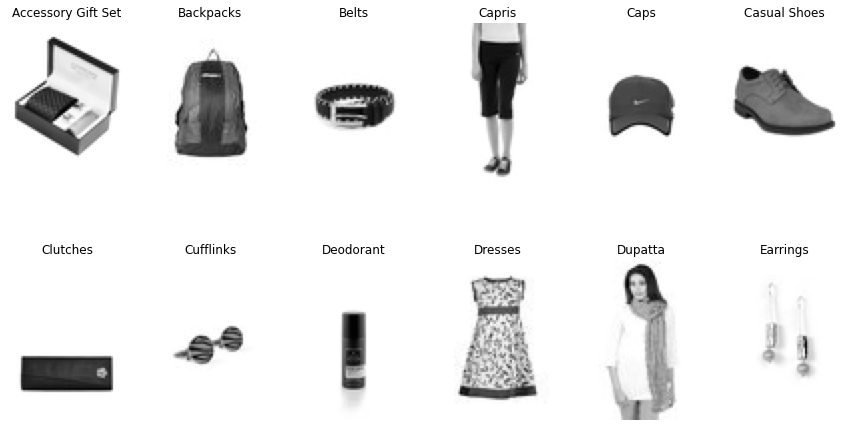

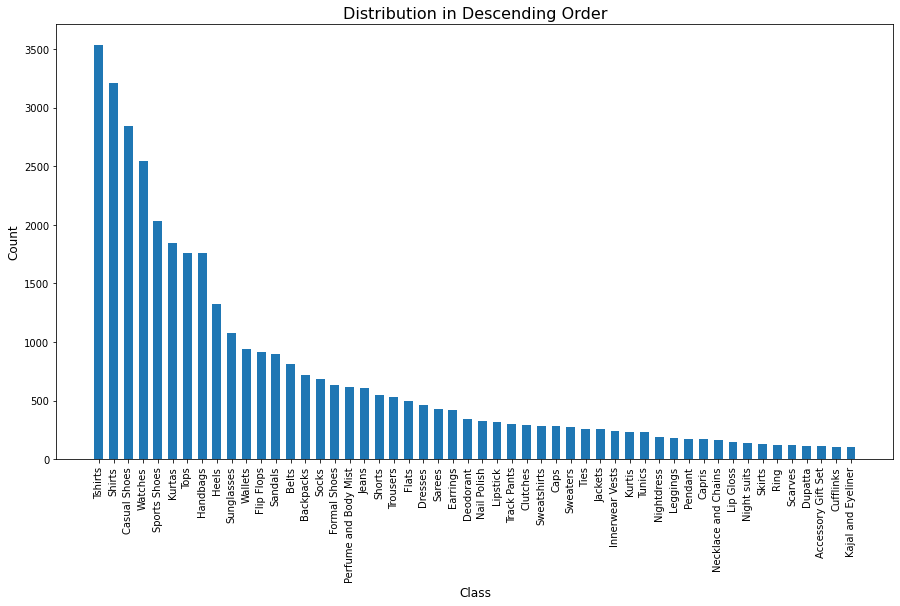

In [ ]:
study_dataset('./categorized_products')

In [9]:
def split_train_test_indices(indices, validation_split):
  split = int(np.floor(validation_split * len(indices)))
  np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]
  return train_idx, test_idx

The neural network that I'm using in this project, is a 5-layer feed forward network. For each image, the output is a vector with the size of total number of categories which represents the probability of belonging to each class. So the predicted category for an image is the one with the highest probability.

In [10]:
class Model(nn.Module):
    def __init__(self, class_num, act = F.relu):
        super(Model, self).__init__()


        self.layer1 = nn.Linear(1 * 80 * 60, 16 * 40 * 30)
        self.act1 = act


        self.layer2 = nn.Linear(16 * 40 * 30, 48 * 10 * 10)
        self.act2 = act



        self.layer3 = nn.Linear(48 * 10 * 10, 96 * 4 * 4)
        self.act3 = act


        self.layer4 = nn.Linear(96 * 4 * 4, 82)
        self.act4 = act

        self.layer5 = nn.Linear(82, class_num)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = self.layer1(x)
        x = self.act1(x)

        x = self.layer2(x)
        x = self.act2(x)

        x = self.layer3(x)
        x = self.act3(x)

        x = self.layer4(x)
        x = self.act4(x)

        x = self.layer5(x)
        return x

In [11]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs = 10):

  total_time = 0.
  average_loss_in_epochs = []
  for epoch in range(num_epochs):
      train_loss = 0.
      d1 = datetime.now()
      for images, labels in train_loader:
          
        images = images.to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()
        train_loss += loss.item()

      average_loss = train_loss / len(train_loader)
      average_loss_in_epochs.append(average_loss)
      d2 = datetime.now()
      delta = d2 - d1
      seconds = float(delta.total_seconds())
      total_time += seconds
      print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))
  print('total training time: %.3f minutes' % (total_time / 60))
  print("-------------------------------------------------------------")
  return average_loss_in_epochs

In [12]:
def print_weights_count(model):
  print("Number of weights:")
  weights_count = sum(p.numel() for p in model.layer1.parameters())
  print("Layer 1:", weights_count)
  weights_count = sum(p.numel() for p in model.layer2.parameters())
  print("Layer 2:", weights_count)
  weights_count = sum(p.numel() for p in model.layer3.parameters())
  print("Layer 3:", weights_count)
  weights_count = sum(p.numel() for p in model.layer4.parameters())
  print("Layer 4:", weights_count)
  weights_count = sum(p.numel() for p in model.layer5.parameters())
  print("Layer 5:", weights_count)
  weights_count = sum(p.numel() for p in model.parameters())
  print("Total number of weights:", weights_count)
  print("-------------------------------------------------------------")

In [13]:
def model_accuracy(model, loader, device):
    # Calculate Accuracy
    correct = 0.
    total = 0.
    all_predicted = []
    all_labels = []
    # Iterate through dataset
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        all_predicted += predicted
        all_labels += labels
    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return all_predicted, all_labels

In [14]:
def print_model_accuracy(model, train_loader, test_loader, device):
  print("Train data:")
  all_predicted_train, all_labels_train = model_accuracy(model, train_loader, device)
  print("Test data:")
  all_predicted_test, all_labels_test = model_accuracy(model, test_loader, device)
  print("-------------------------------------------------------------")
  return all_predicted_train, all_labels_train, all_predicted_test, all_labels_test

In [15]:
def calc_recall_per_class(all_predicted, all_labels, classes):
    correct_count_per_class = {classes[i] : 0 for i in range(len(classes))}
    total_count_per_class = {classes[i] : 0 for i in range(len(classes))}
    accuracy_per_class = []
    for i in range(len(all_predicted)):
        label = all_labels[i]
        total_count_per_class[classes[label]] += 1
        correct_count_per_class[classes[label]] += (all_predicted[i].to('cpu') == label).item()
    for c in classes:
        class_correct = correct_count_per_class[c]
        class_total = total_count_per_class[c]
        class_accuracy = 100 * class_correct / class_total
        accuracy_per_class.append(class_accuracy)
    return accuracy_per_class

In [16]:
def plot_recalls_for_model(all_predicted_train, all_labels_train, all_predicted_test, all_labels_test, classes):
  accuracy_per_class_train = calc_recall_per_class(all_predicted_train, all_labels_train, classes)
  accuracy_per_class_test = calc_recall_per_class(all_predicted_test, all_labels_test, classes)
  train_df = pd.DataFrame({"Class": classes, "Accuracy": accuracy_per_class_train})
  test_df = pd.DataFrame({"Class": classes, "Accuracy": accuracy_per_class_test})

  index = np.arange(len(classes))
  w = 0.3
  plt.figure(figsize=(18,6))
  plt.bar(index, 'Accuracy', data = train_df, width = w, color = 'b', label = 'train')
  plt.bar(index + w, 'Accuracy', data = test_df, width = w, color = 'r', label = 'test')
  plt.legend(loc = "best")
  plt.xlabel("Class", size = 12)
  plt.xticks(index + w, classes, rotation = 90)
  plt.ylabel("Accuracy", size = 12)
  plt.title("Accuracy per class", size = 16)
  plt.show()

In [17]:
def plot_average_loss(average_loss_in_epochs):
  x = list(i + 1 for i in range(len(average_loss_in_epochs)))
  # print(average_loss_in_epochs)
  plt.plot(x, average_loss_in_epochs)
  plt.xlabel("Epoch", size = 12)
  plt.xticks(x)
  plt.ylabel("Average loss", size = 12)
  plt.title("Average loss changes", size = 16)
  plt.show()

First we must load our dataset and perform any needed process. By practice we know that neural networks are sensitive to the color or position of objects. In this project, we use grayscale transform to create black-and-white images for simplicity. Then we convert images to tensors. <br>
We have to split our dataset into train and test data. We choose 80 percents of each class for training and leave the other 20 percents for testing. We use mini-batch stochastic gradient descent as our optimization algorithm. So we split the datasets into small batches that are used to calculate model error and update model coefficients. SGD updates the weights using an average of the gradients for a mini-batch. The default batch size is 64 in this project. It's good to know that when number of workers is 16, it means that at most 16 workers are simultaneously putting data into RAM.


In [18]:
def load_split(dataset_folder, selected_transform, batch_size):
  transform = transforms.Compose([transforms.Grayscale(),
                                selected_transform()
                               ]
                              ) ## composes multiple transforms into single one

  dataset = ImageFolder(dataset_folder, transform=transform)

  classes = dataset.classes
  all_loader = torch.utils.data.DataLoader(dataset)
  images_indices_per_class = get_images_indices_per_class(all_loader, classes)
  
  validation_split = 0.2

  # Splitting the dataset into train and test sets randomly with split of 0.2 and assign their indices in the original set to train_indices and test_indices: 
  train_indices = []
  test_indices = []
  for c in images_indices_per_class:
    class_indices = images_indices_per_class[c]
    class_train_idx, class_test_idx = split_train_test_indices(class_indices, validation_split)
    for index in class_train_idx:
      train_indices.append(index)
    for index in class_test_idx:
      test_indices.append(index)

  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=16)
  return classes, train_loader, test_loader

In [19]:
def init_all_weights_to_zero(model):
  nn.init.zeros_(model.layer1.weight)
  nn.init.zeros_(model.layer1.bias)
  nn.init.zeros_(model.layer2.weight)
  nn.init.zeros_(model.layer2.bias)
  nn.init.zeros_(model.layer3.weight)
  nn.init.zeros_(model.layer3.bias)
  nn.init.zeros_(model.layer4.weight)
  nn.init.zeros_(model.layer4.bias)
  nn.init.zeros_(model.layer5.weight)
  nn.init.zeros_(model.layer5.bias)

In [20]:
def print_weights(model):
  print("weight and bias values:")
  print("Layer 1:")
  print(model.layer1.weight)
  print(model.layer1.bias)
  print("Layer 2:")
  print(model.layer2.weight)
  print(model.layer2.bias)
  print("Layer 3:")
  print(model.layer3.weight)
  print(model.layer3.bias)
  print("Layer 4:")
  print(model.layer4.weight)
  print(model.layer4.bias)
  print("Layer 5:")
  print(model.layer5.weight)
  print(model.layer5.bias)
  print("-------------------------------------------------------------")

Some defaults are considered in this project: 

*   The default loss function is cross entropy loss.
*   The optimization method is Stochastic Gradient Descent.
*   The default batch size is 64.
*   Number of epochs is 10 by default.
*   The learning rate is set to 0.01.
*   The activation function used in all layers is ReLU.
*   The initialization of layers' weights and biases is random.







In [21]:
def run_network(dataset_folder = './categorized_products', selected_transform = CustomToTensor, 
                all_weights_to_zero = False, batch_size = 64, learning_rate = 0.01, mo = 0,
                epochs = 10, activation_func = F.relu, wd = 0,
                show_device = False, show_weights_count = False):
  classes, train_loader, test_loader =\
   load_split(dataset_folder, selected_transform, batch_size)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  if show_device:
    print(device)
    print("-------------------------------------------------------------")

  model = Model(len(classes), act = activation_func)
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, 
                              momentum = mo, weight_decay = wd)

  if all_weights_to_zero:
    init_all_weights_to_zero(model)
    
  if show_weights_count:
    print_weights_count(model)

  average_loss_in_epochs =\
  fit(model, train_loader, device, criterion, optimizer, num_epochs = epochs)

  all_predicted_train, all_labels_train, all_predicted_test, all_labels_test =\
    print_model_accuracy(model, train_loader, test_loader, device)
  plot_recalls_for_model(all_predicted_train, all_labels_train, all_predicted_test, all_labels_test, classes)
  plot_average_loss(average_loss_in_epochs)

We can see the number of trainable parameters in each layer. These numbers are calculable with the number of inputs and outputs of each layer:<br> 
The number of weights in a layer is <i>#inputs * #neurons</i> and the number of biases is <i>#neurons</i>.

We didn't normalize our inputs in this part. The inputs are between 0 and 255, while cross entropy loss function is used. Cross entropy loss measures the performance of a classification model whose output is a probability value between 0 and 1. So the loss values are huge (NaN) and the model is not trained and It always predicts the first category which is about 0.3% of all images.

cuda:0
-------------------------------------------------------------
Number of weights:
Layer 1: 92179200
Layer 2: 92164800
Layer 3: 7374336
Layer 4: 126034
Layer 5: 4316
Total number of weights: 191848686
-------------------------------------------------------------
epoch 1, train_loss: nan, time elapsed: 35.950804 seconds
epoch 2, train_loss: nan, time elapsed: 36.061036 seconds
epoch 3, train_loss: nan, time elapsed: 36.000775 seconds
epoch 4, train_loss: nan, time elapsed: 35.988791 seconds
epoch 5, train_loss: nan, time elapsed: 36.022883 seconds
epoch 6, train_loss: nan, time elapsed: 35.936529 seconds
epoch 7, train_loss: nan, time elapsed: 35.994498 seconds
epoch 8, train_loss: nan, time elapsed: 36.145637 seconds
epoch 9, train_loss: nan, time elapsed: 36.045298 seconds
epoch 10, train_loss: nan, time elapsed: 35.929042 seconds
total training time: 6.001 minutes
-------------------------------------------------------------
Train data:
Accuracy: 0.29845741113346747%
Test data:


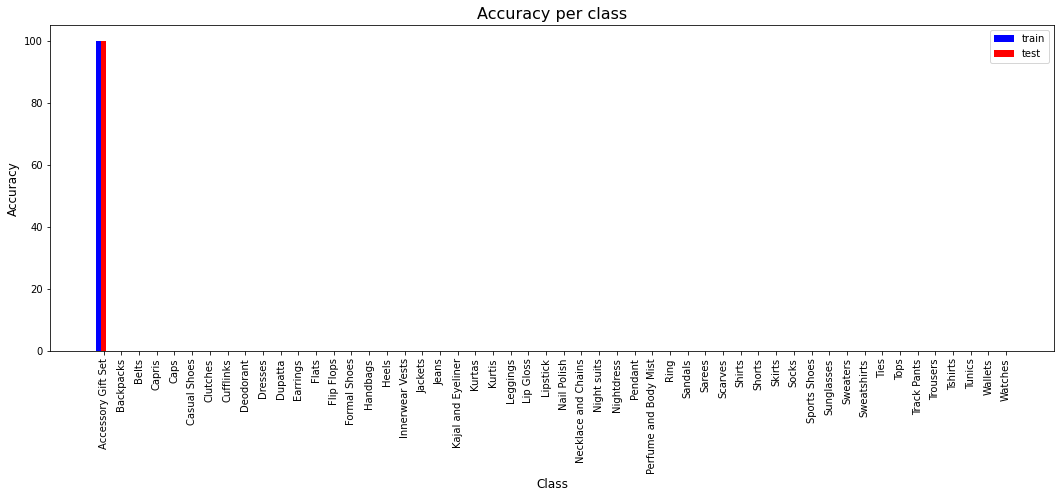

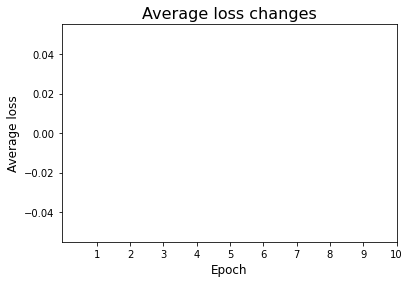

In [ ]:
run_network(show_device = True, show_weights_count = True)

Now we noramalize our input using ToTensor transform. The inputs are between 0 and 1 after normalization. We can see that it leads to a well-trained network and increases the accuracy obviously.

epoch 1, train_loss: 3.332, time elapsed: 37.584046 seconds
epoch 2, train_loss: 2.627, time elapsed: 37.509589 seconds
epoch 3, train_loss: 2.171, time elapsed: 37.558383 seconds
epoch 4, train_loss: 1.858, time elapsed: 37.520035 seconds
epoch 5, train_loss: 1.688, time elapsed: 37.563546 seconds
epoch 6, train_loss: 1.565, time elapsed: 37.50602 seconds
epoch 7, train_loss: 1.482, time elapsed: 37.518522 seconds
epoch 8, train_loss: 1.414, time elapsed: 37.550672 seconds
epoch 9, train_loss: 1.348, time elapsed: 37.523269 seconds
epoch 10, train_loss: 1.307, time elapsed: 37.552735 seconds
total training time: 6.256 minutes
-------------------------------------------------------------
Train data:
Accuracy: 59.31924882629108%
Test data:
Accuracy: 58.28509893659981%
-------------------------------------------------------------


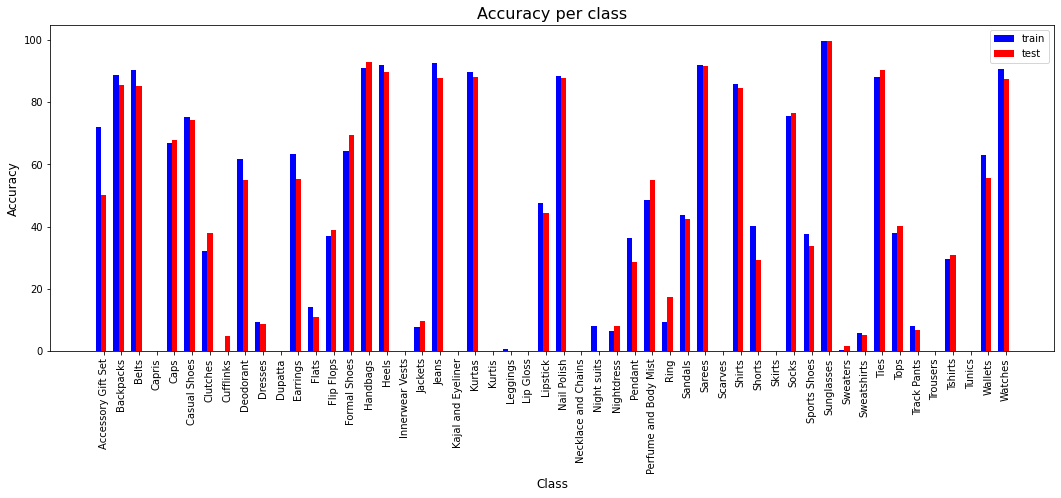

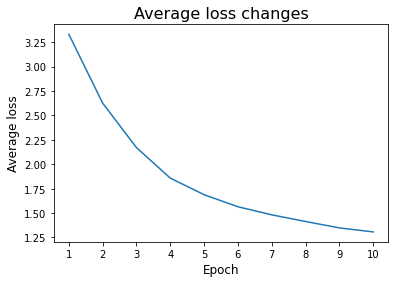

In [ ]:
run_network(selected_transform = transforms.ToTensor)

The initial weights of a network are important. We know that the default initialization is with random numbers. In this part we initialize all of the weights to zero. The accuracy decreases awfully. If all our weights are initialized to zero, all the neurons at each layer are producing the same output. They will also have the value of the same gradient flowing back during backpropagation and undergo the exact same parameter updates. So after all iterations, the weights are going to remain the same. This prevents different neurons from learning different things and eventually prevents the model from learning. So the category with the most number of samples is predicted every time and the accuracy is only as much as its proportion.

The weights shouldn't be initialized with very high or very low values. To prevent the gradients from vanishing or exploding, the mean of activation should be zero and the variance should remain the same across every layer. A good initialization method for ReLU is He initialization. In this method, we simply multiply random initialization with sqrt(2 / size_l - 1).

epoch 1, train_loss: 3.896, time elapsed: 19.907509 seconds
epoch 2, train_loss: 3.798, time elapsed: 19.825578 seconds
epoch 3, train_loss: 3.721, time elapsed: 19.793345 seconds
epoch 4, train_loss: 3.661, time elapsed: 19.960795 seconds
epoch 5, train_loss: 3.616, time elapsed: 20.008668 seconds
epoch 6, train_loss: 3.583, time elapsed: 19.956732 seconds
epoch 7, train_loss: 3.558, time elapsed: 19.975386 seconds
epoch 8, train_loss: 3.539, time elapsed: 19.968306 seconds
epoch 9, train_loss: 3.524, time elapsed: 20.09924 seconds
epoch 10, train_loss: 3.513, time elapsed: 20.000621 seconds
total training time: 3.325 minutes
-------------------------------------------------------------
Train data:
Accuracy: 9.48356807511737%
Test data:
Accuracy: 9.503297886660384%
-------------------------------------------------------------


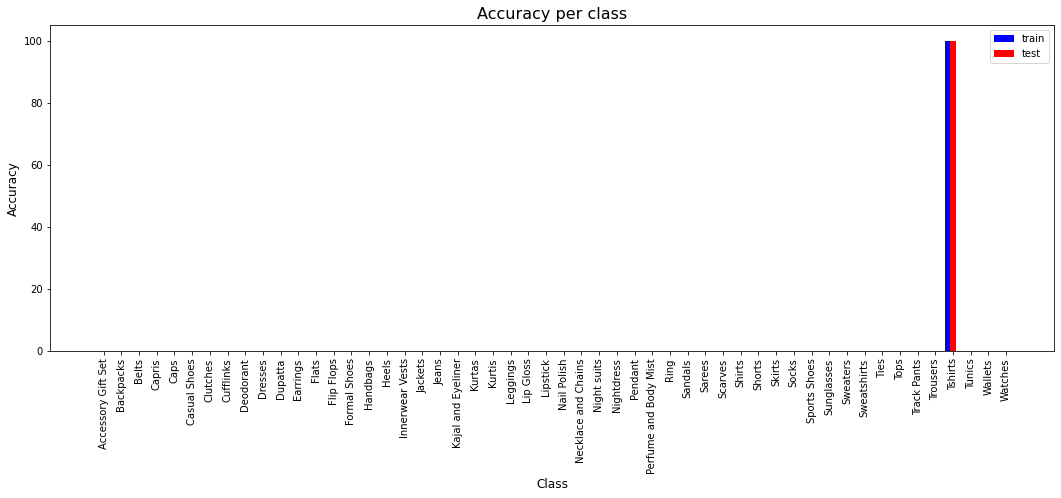

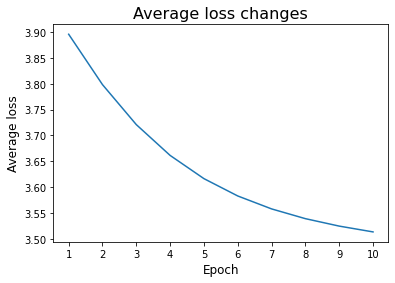

In [22]:
run_network(selected_transform = transforms.ToTensor, all_weights_to_zero = True)

One of the important parameters in training a neural network is learning rate. The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. In other words, it controls how quickly the model is adapted to the problem. With testing different numbers, we see that 0.05 is an optimal learning rate and leads to a relatively high accuracy. Any learning rate which is less or more than 0.05 results in lower accuracy.

If learning rate is too low, training will progress very slowly as we are making very tiny updates to the weights in our network. However, if learning rate is set too high, it can cause undesirable divergent behavior. So in both cases, the accuracy is low and the network is not trained well.

Learning rate =  0.001
epoch 1, train_loss: 3.883, time elapsed: 20.514174 seconds
epoch 2, train_loss: 3.639, time elapsed: 20.333033 seconds
epoch 3, train_loss: 3.470, time elapsed: 20.301747 seconds
epoch 4, train_loss: 3.432, time elapsed: 20.34225 seconds
epoch 5, train_loss: 3.401, time elapsed: 20.423664 seconds
epoch 6, train_loss: 3.357, time elapsed: 20.316321 seconds
epoch 7, train_loss: 3.284, time elapsed: 20.392413 seconds
epoch 8, train_loss: 3.166, time elapsed: 20.35964 seconds
epoch 9, train_loss: 3.034, time elapsed: 20.521119 seconds
epoch 10, train_loss: 2.924, time elapsed: 20.418577 seconds
total training time: 3.399 minutes
-------------------------------------------------------------
Train data:
Accuracy: 23.028169014084508%
Test data:
Accuracy: 22.82945214699152%
-------------------------------------------------------------


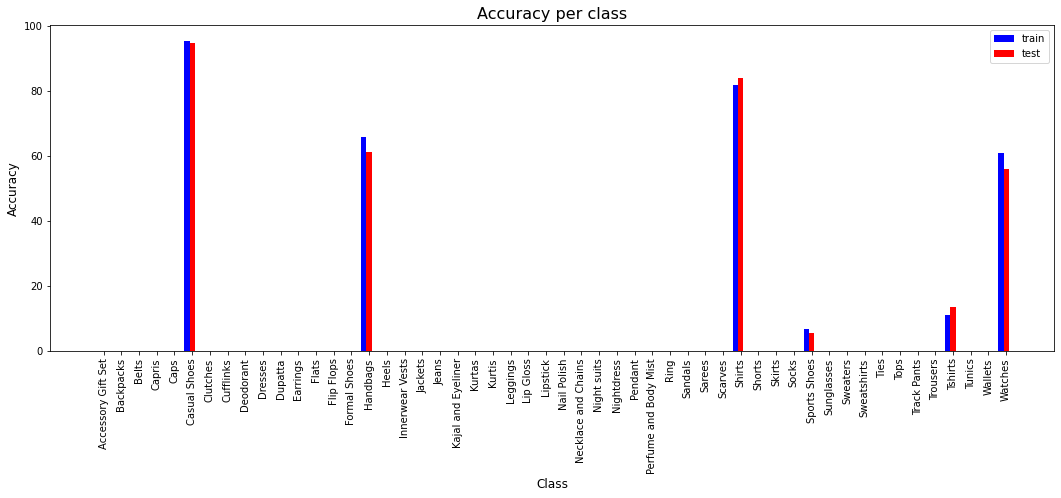

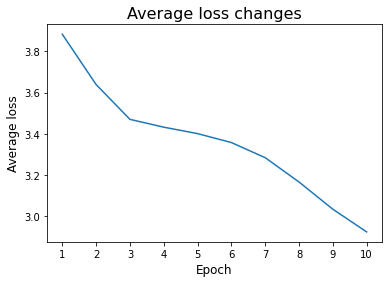

Learning rate =  0.004
epoch 1, train_loss: 3.635, time elapsed: 20.705959 seconds
epoch 2, train_loss: 3.343, time elapsed: 20.845269 seconds
epoch 3, train_loss: 2.945, time elapsed: 20.633834 seconds
epoch 4, train_loss: 2.618, time elapsed: 20.531391 seconds
epoch 5, train_loss: 2.346, time elapsed: 20.500838 seconds
epoch 6, train_loss: 2.160, time elapsed: 20.445718 seconds
epoch 7, train_loss: 1.998, time elapsed: 20.436433 seconds
epoch 8, train_loss: 1.865, time elapsed: 20.437278 seconds
epoch 9, train_loss: 1.750, time elapsed: 20.57675 seconds
epoch 10, train_loss: 1.657, time elapsed: 20.40766 seconds
total training time: 3.425 minutes
-------------------------------------------------------------
Train data:
Accuracy: 49.23876592890677%
Test data:
Accuracy: 49.61636828644501%
-------------------------------------------------------------


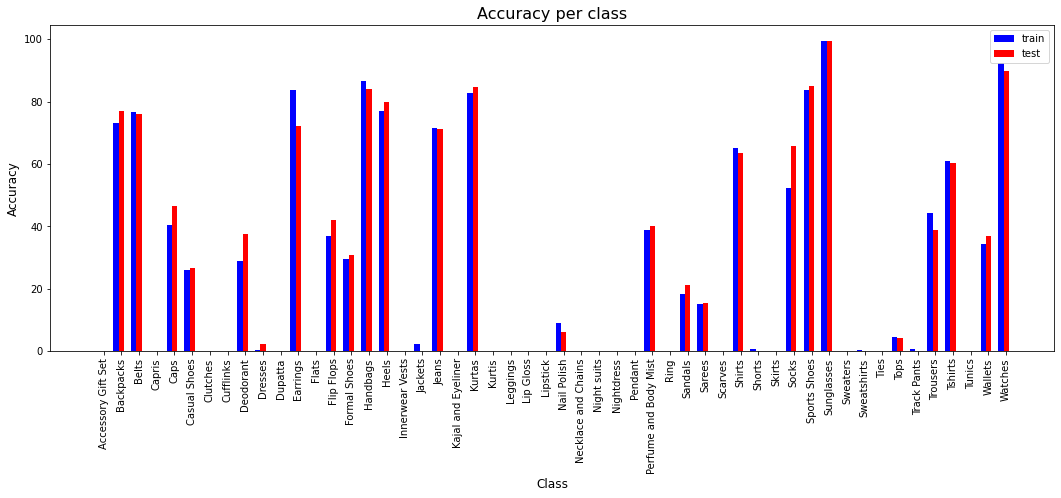

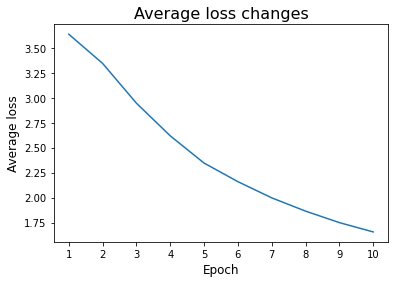

Learning rate =  0.007
epoch 1, train_loss: 3.495, time elapsed: 20.481145 seconds
epoch 2, train_loss: 2.925, time elapsed: 20.682626 seconds
epoch 3, train_loss: 2.537, time elapsed: 20.490674 seconds
epoch 4, train_loss: 2.222, time elapsed: 20.457595 seconds
epoch 5, train_loss: 1.966, time elapsed: 20.406061 seconds
epoch 6, train_loss: 1.802, time elapsed: 20.681589 seconds
epoch 7, train_loss: 1.674, time elapsed: 20.396927 seconds
epoch 8, train_loss: 1.593, time elapsed: 20.475651 seconds
epoch 9, train_loss: 1.517, time elapsed: 20.388759 seconds
epoch 10, train_loss: 1.457, time elapsed: 20.415026 seconds
total training time: 3.415 minutes
-------------------------------------------------------------
Train data:
Accuracy: 56.07981220657277%
Test data:
Accuracy: 55.350652846951135%
-------------------------------------------------------------


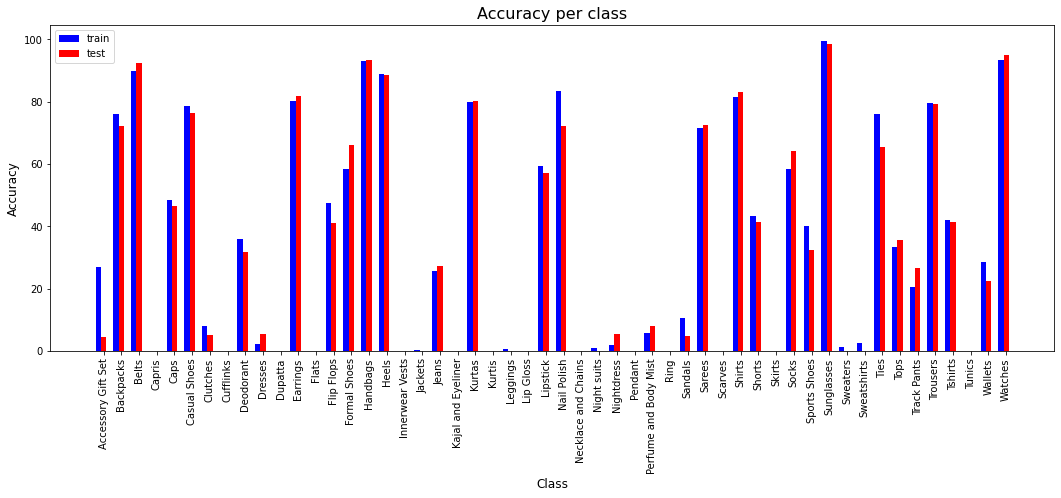

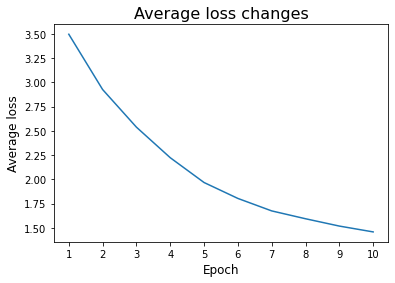

Learning rate =  0.03
epoch 1, train_loss: 2.940, time elapsed: 20.494691 seconds
epoch 2, train_loss: 2.046, time elapsed: 20.62663 seconds
epoch 3, train_loss: 1.729, time elapsed: 20.510479 seconds
epoch 4, train_loss: 1.526, time elapsed: 20.376116 seconds
epoch 5, train_loss: 1.380, time elapsed: 20.438232 seconds
epoch 6, train_loss: 1.286, time elapsed: 20.465259 seconds
epoch 7, train_loss: 1.208, time elapsed: 20.447685 seconds
epoch 8, train_loss: 1.164, time elapsed: 20.406167 seconds
epoch 9, train_loss: 1.108, time elapsed: 20.530894 seconds
epoch 10, train_loss: 1.049, time elapsed: 20.569879 seconds
total training time: 3.414 minutes
-------------------------------------------------------------
Train data:
Accuracy: 67.07578806170355%
Test data:
Accuracy: 65.90389016018307%
-------------------------------------------------------------


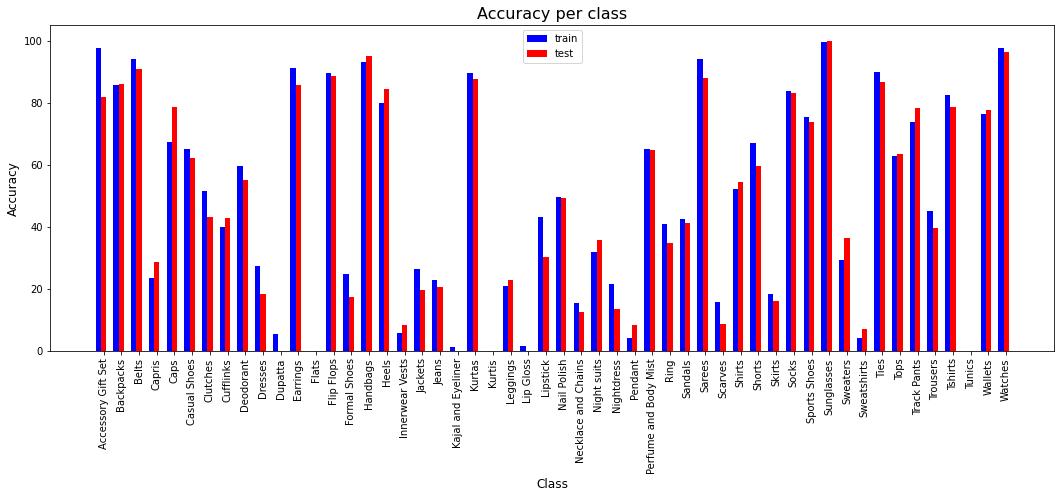

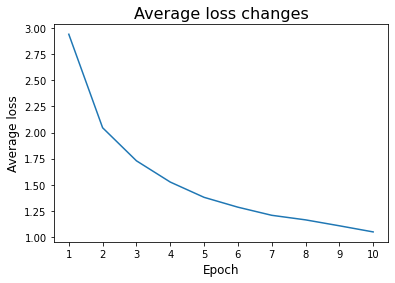

Learning rate =  0.05
epoch 1, train_loss: 2.777, time elapsed: 20.519309 seconds
epoch 2, train_loss: 1.989, time elapsed: 20.588357 seconds
epoch 3, train_loss: 1.635, time elapsed: 20.473336 seconds
epoch 4, train_loss: 1.468, time elapsed: 20.420725 seconds
epoch 5, train_loss: 1.330, time elapsed: 20.528884 seconds
epoch 6, train_loss: 1.233, time elapsed: 20.407741 seconds
epoch 7, train_loss: 1.170, time elapsed: 20.519585 seconds
epoch 8, train_loss: 1.115, time elapsed: 20.459889 seconds
epoch 9, train_loss: 1.059, time elapsed: 20.385114 seconds
epoch 10, train_loss: 1.018, time elapsed: 20.445043 seconds
total training time: 3.412 minutes
-------------------------------------------------------------
Train data:
Accuracy: 67.38430583501005%
Test data:
Accuracy: 66.50962444474358%
-------------------------------------------------------------


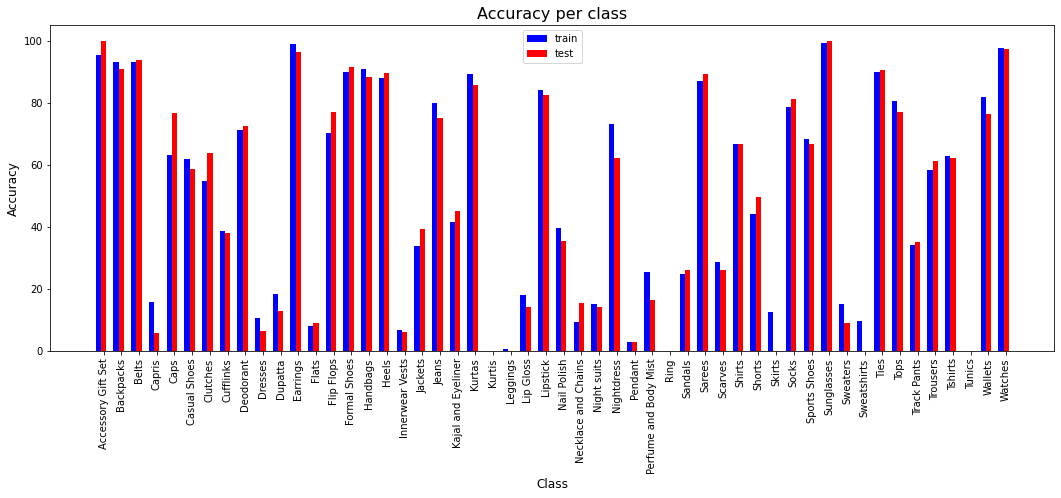

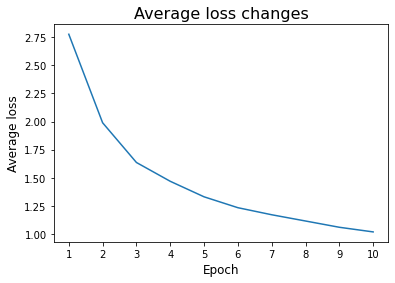

Learning rate =  0.1
epoch 1, train_loss: 2.958, time elapsed: 20.5121 seconds
epoch 2, train_loss: 2.118, time elapsed: 20.51565 seconds
epoch 3, train_loss: 1.808, time elapsed: 20.426064 seconds
epoch 4, train_loss: 1.590, time elapsed: 20.350515 seconds
epoch 5, train_loss: 1.452, time elapsed: 20.395303 seconds
epoch 6, train_loss: 1.316, time elapsed: 20.350998 seconds
epoch 7, train_loss: 1.219, time elapsed: 20.350929 seconds
epoch 8, train_loss: 1.170, time elapsed: 20.419407 seconds
epoch 9, train_loss: 1.099, time elapsed: 20.538828 seconds
epoch 10, train_loss: 1.062, time elapsed: 20.438368 seconds
total training time: 3.405 minutes
-------------------------------------------------------------
Train data:
Accuracy: 66.55935613682092%
Test data:
Accuracy: 65.75582177951271%
-------------------------------------------------------------


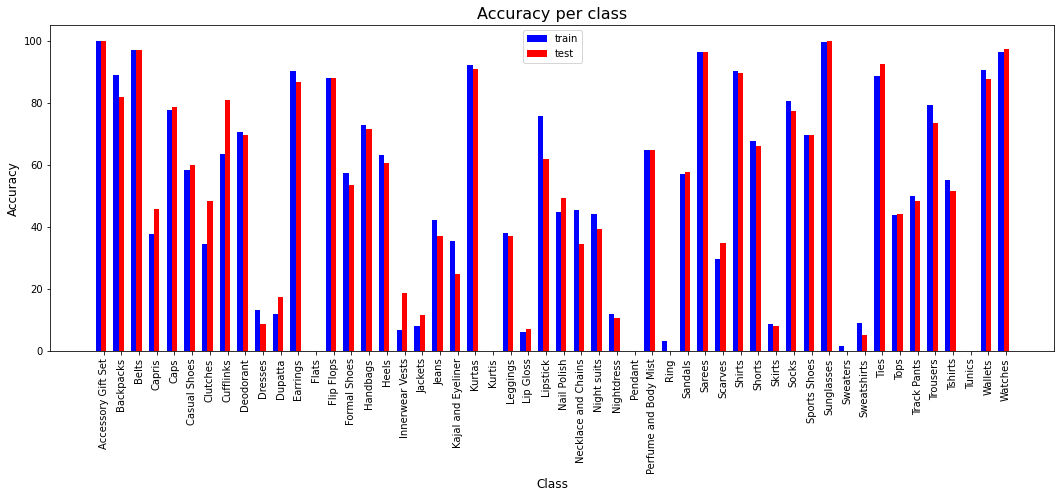

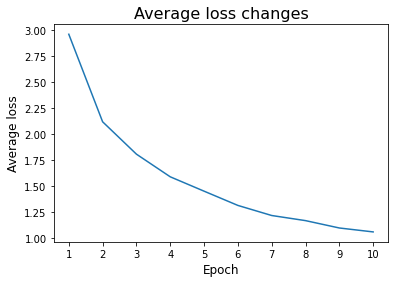

In [23]:
lr_list = [0.001, 0.004, 0.007, 0.03, 0.05, 0.1]
for lr in lr_list:
  print("Learning rate = ", lr)
  run_network(selected_transform = transforms.ToTensor, learning_rate = lr)

In [24]:
optimal_lr = 0.05

With the batch size of 32 which is less than our default batch size (64), the accuracy increases. However, batch size of 128, results in lower accuracy. <br>
Using too large batch sizes can have negative effect on the accuracy of network during training. It is well known that too large of a batch size will lead to poor generalization. Computational speed is usually higher with a larger batch. However, this is at the cost of slower convergence. In other words, a larger batch size will require training the network for more epochs to achieve a good accuracy. <br> 
On the other hand, using a smaller batch size produces choppier, more stochastic weight updates. It can both help and hurt convergence since updating the weights based on a small batch will be more noisy. As we take steps with regard to a small sample, we wander around a bit, but on the average we head towards a good result.

epoch 1, train_loss: 2.529, time elapsed: 32.1814 seconds
epoch 2, train_loss: 1.745, time elapsed: 32.252286 seconds
epoch 3, train_loss: 1.456, time elapsed: 32.233587 seconds
epoch 4, train_loss: 1.321, time elapsed: 32.140773 seconds
epoch 5, train_loss: 1.215, time elapsed: 32.21813 seconds
epoch 6, train_loss: 1.119, time elapsed: 32.131431 seconds
epoch 7, train_loss: 1.058, time elapsed: 32.127054 seconds
epoch 8, train_loss: 1.013, time elapsed: 32.165157 seconds
epoch 9, train_loss: 0.966, time elapsed: 32.143679 seconds
epoch 10, train_loss: 0.921, time elapsed: 32.26084 seconds
total training time: 5.364 minutes
-------------------------------------------------------------
Train data:
Accuracy: 71.41180415828303%
Test data:
Accuracy: 69.75366805761206%
-------------------------------------------------------------


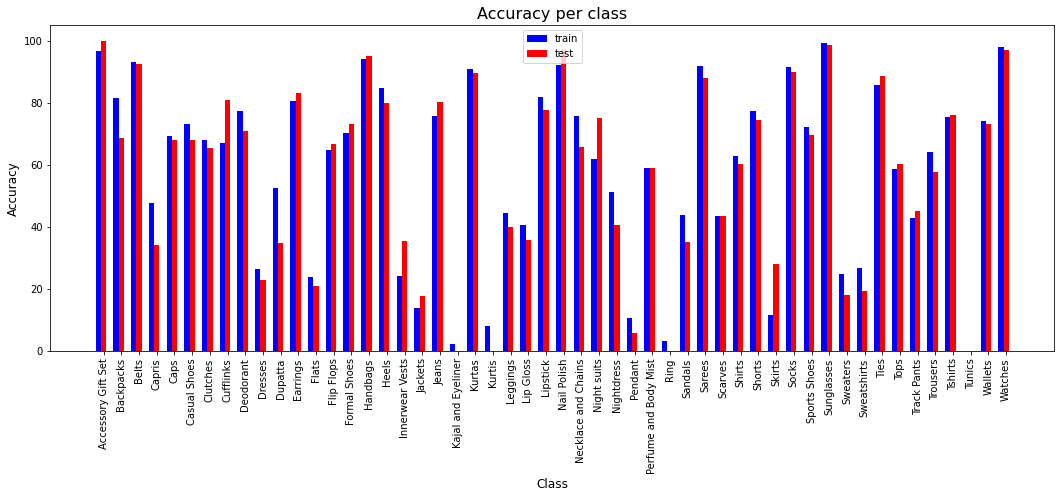

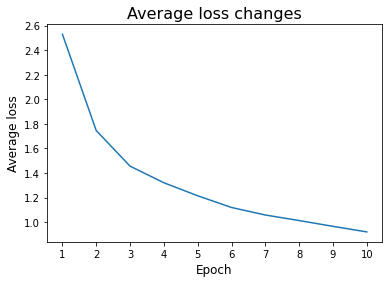

epoch 1, train_loss: 3.044, time elapsed: 15.205636 seconds
epoch 2, train_loss: 2.282, time elapsed: 15.393936 seconds
epoch 3, train_loss: 1.961, time elapsed: 15.191639 seconds
epoch 4, train_loss: 1.746, time elapsed: 15.0686 seconds
epoch 5, train_loss: 1.573, time elapsed: 15.001459 seconds
epoch 6, train_loss: 1.446, time elapsed: 15.006245 seconds
epoch 7, train_loss: 1.340, time elapsed: 15.214561 seconds
epoch 8, train_loss: 1.295, time elapsed: 15.225361 seconds
epoch 9, train_loss: 1.239, time elapsed: 15.104333 seconds
epoch 10, train_loss: 1.173, time elapsed: 15.05823 seconds
total training time: 2.525 minutes
-------------------------------------------------------------
Train data:
Accuracy: 61.82763246143528%
Test data:
Accuracy: 60.54650693229237%
-------------------------------------------------------------


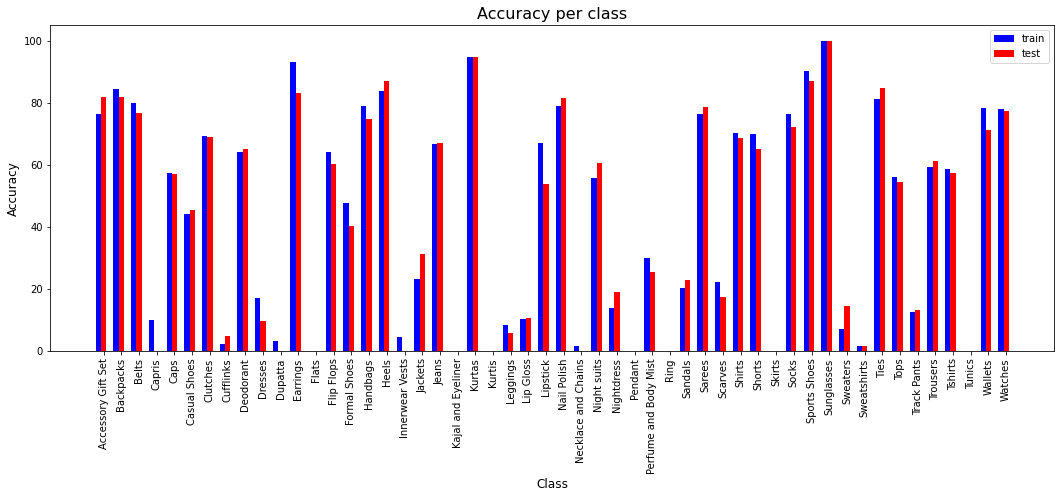

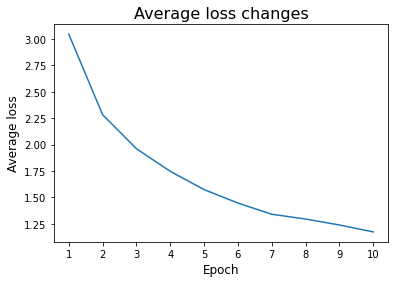

In [25]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr, batch_size = 32)
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr, batch_size = 128)

As we can see from the results below, we can somewhat recover the lost accuracy from a larger batch size by increasing the learning rate. I also assume that the learning rate should increase to result in better accuracy, since the gradient will be less noisy with a higher batch size.

epoch 1, train_loss: 3.347, time elapsed: 15.394626 seconds
epoch 2, train_loss: 2.648, time elapsed: 15.224063 seconds
epoch 3, train_loss: 2.167, time elapsed: 15.015776 seconds
epoch 4, train_loss: 1.902, time elapsed: 14.934938 seconds
epoch 5, train_loss: 1.738, time elapsed: 15.039835 seconds
epoch 6, train_loss: 1.644, time elapsed: 15.124878 seconds
epoch 7, train_loss: 1.526, time elapsed: 15.231643 seconds
epoch 8, train_loss: 1.458, time elapsed: 15.254783 seconds
epoch 9, train_loss: 1.388, time elapsed: 15.03902 seconds
epoch 10, train_loss: 1.336, time elapsed: 15.056105 seconds
total training time: 2.522 minutes
-------------------------------------------------------------
Train data:
Accuracy: 58.68544600938967%
Test data:
Accuracy: 58.89083322116032%
-------------------------------------------------------------


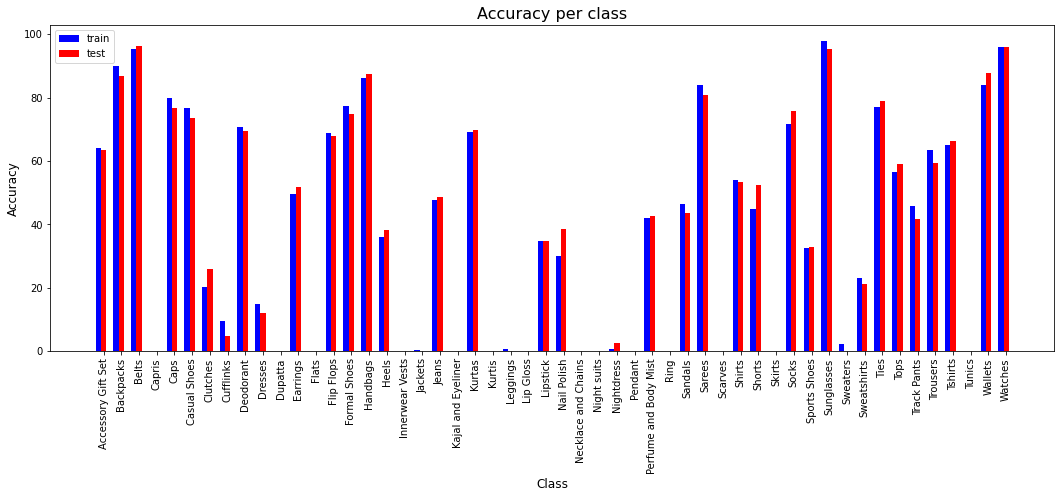

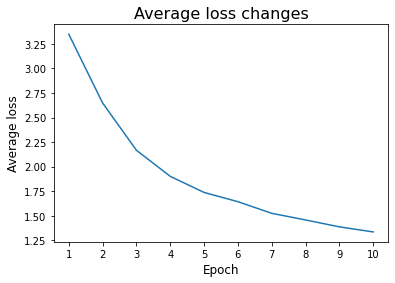

epoch 1, train_loss: 3.066, time elapsed: 15.129124 seconds
epoch 2, train_loss: 2.316, time elapsed: 15.392502 seconds
epoch 3, train_loss: 2.000, time elapsed: 15.142727 seconds
epoch 4, train_loss: 1.721, time elapsed: 14.947067 seconds
epoch 5, train_loss: 1.635, time elapsed: 14.992154 seconds
epoch 6, train_loss: 1.473, time elapsed: 15.095985 seconds
epoch 7, train_loss: 1.390, time elapsed: 15.061994 seconds
epoch 8, train_loss: 1.303, time elapsed: 15.085031 seconds
epoch 9, train_loss: 1.244, time elapsed: 14.990558 seconds
epoch 10, train_loss: 1.185, time elapsed: 14.982817 seconds
total training time: 2.514 minutes
-------------------------------------------------------------
Train data:
Accuracy: 65.25821596244131%
Test data:
Accuracy: 63.400188450666306%
-------------------------------------------------------------


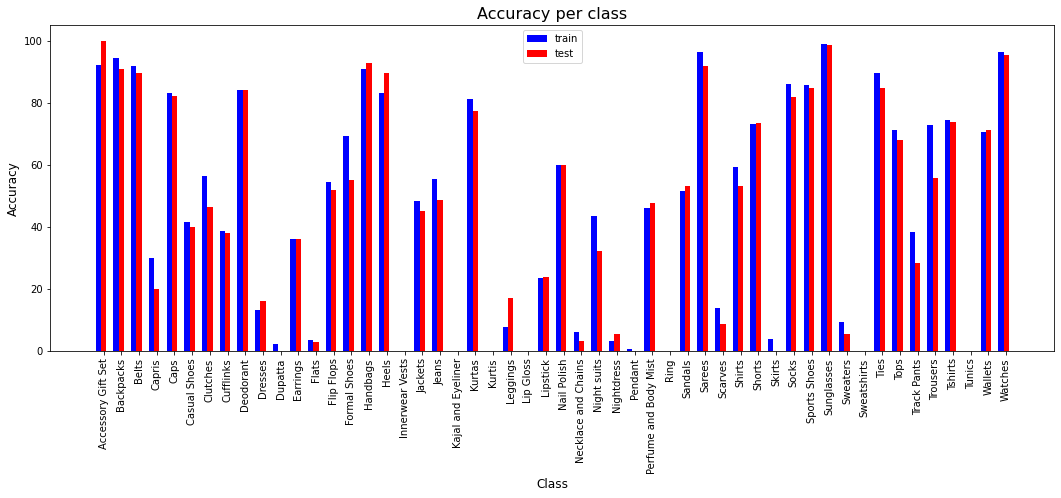

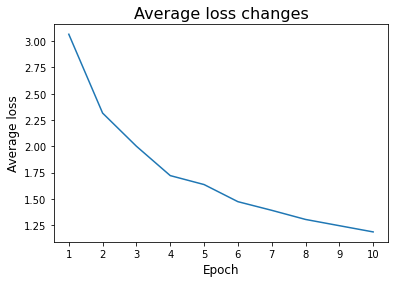

In [26]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr - optimal_lr / 2, batch_size = 128)
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr + optimal_lr / 2, batch_size = 128)

Momentum is used to speed up convergence. We add what’s called the momentum term to the update formula for gradient descent. In other words, the weight delta equals the learning rate times the gradient, plus a momentum factor times the weight delta from the previous iteration. If you include a momentum term, then instead of just relying on the gradient at each new stopping point to determine your movement, your direction now also depends on the size and direction of your movement in the previous update. As a result, each movement depends on the entire history of previous movements. So we won't get stuck in a local minima and we can obtain a higher accuracy in less time.

Increaing the momentum doesn't essentially result in higher accuracy. This can be seen in the results below with momentums of 0.9 and 0.98. If both the momentum and learning rate are kept at large values (if the momentum is aggressive relative to the learning rate), then we might skip the minimum loss with a huge step. 

epoch 1, train_loss: 2.573, time elapsed: 27.667033 seconds
epoch 2, train_loss: 1.756, time elapsed: 27.536608 seconds
epoch 3, train_loss: 1.433, time elapsed: 27.528827 seconds
epoch 4, train_loss: 1.299, time elapsed: 27.604672 seconds
epoch 5, train_loss: 1.205, time elapsed: 27.532318 seconds
epoch 6, train_loss: 1.115, time elapsed: 27.559242 seconds
epoch 7, train_loss: 1.082, time elapsed: 27.696385 seconds
epoch 8, train_loss: 1.019, time elapsed: 27.77559 seconds
epoch 9, train_loss: 0.965, time elapsed: 27.695152 seconds
epoch 10, train_loss: 0.936, time elapsed: 27.761382 seconds
total training time: 4.606 minutes
-------------------------------------------------------------
Train data:
Accuracy: 68.67873910127432%
Test data:
Accuracy: 68.3941311078207%
-------------------------------------------------------------


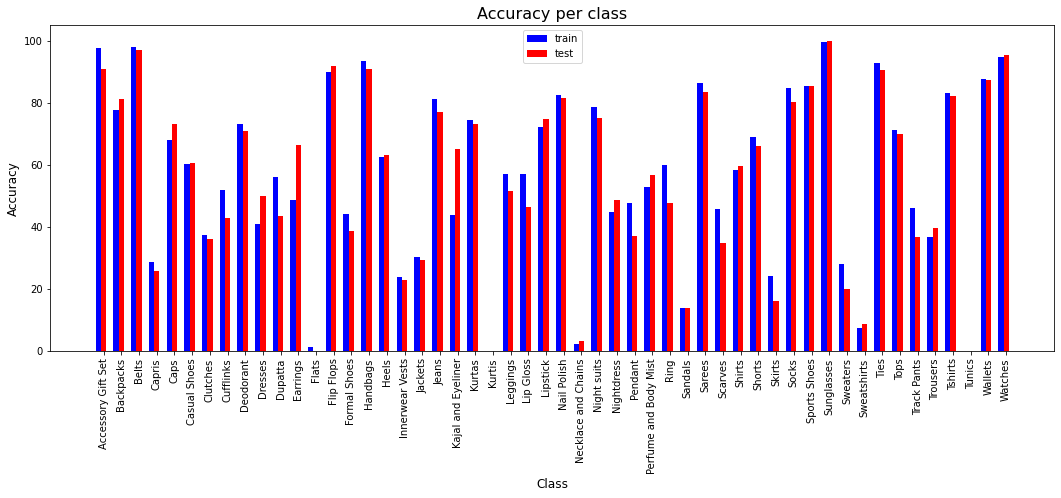

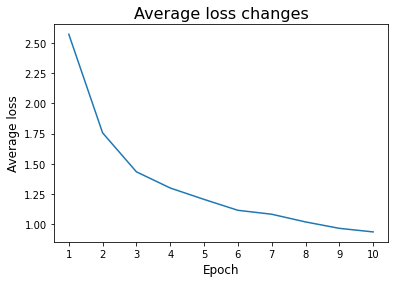

In [27]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr, mo = 0.5)

epoch 1, train_loss: 2.648, time elapsed: 27.597239 seconds
epoch 2, train_loss: 2.558, time elapsed: 27.459857 seconds
epoch 3, train_loss: 3.159, time elapsed: 27.353873 seconds
epoch 4, train_loss: 3.456, time elapsed: 27.428227 seconds
epoch 5, train_loss: 3.453, time elapsed: 27.498946 seconds
epoch 6, train_loss: 3.453, time elapsed: 27.413841 seconds
epoch 7, train_loss: 3.453, time elapsed: 27.448696 seconds
epoch 8, train_loss: 3.453, time elapsed: 27.407008 seconds
epoch 9, train_loss: 3.453, time elapsed: 27.392331 seconds
epoch 10, train_loss: 3.453, time elapsed: 27.374006 seconds
total training time: 4.573 minutes
-------------------------------------------------------------
Train data:
Accuracy: 9.48356807511737%
Test data:
Accuracy: 9.503297886660384%
-------------------------------------------------------------


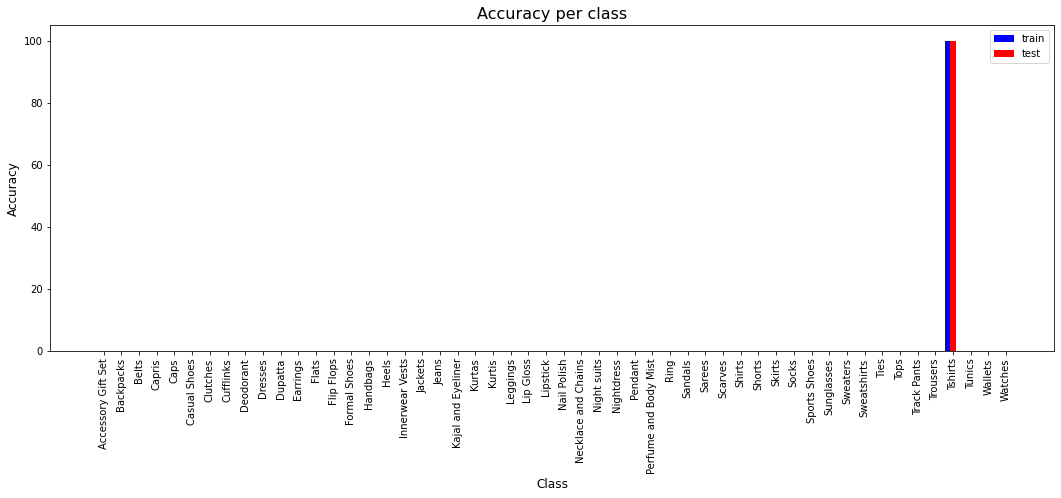

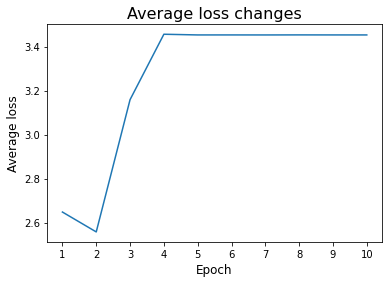

In [28]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr, mo = 0.9)

epoch 1, train_loss: 3.479, time elapsed: 15.821093 seconds
epoch 2, train_loss: 3.460, time elapsed: 15.800454 seconds
epoch 3, train_loss: 3.461, time elapsed: 15.775657 seconds
epoch 4, train_loss: 3.460, time elapsed: 15.85982 seconds
epoch 5, train_loss: 3.461, time elapsed: 15.735293 seconds
epoch 6, train_loss: 3.460, time elapsed: 15.800755 seconds
epoch 7, train_loss: 3.462, time elapsed: 15.863521 seconds
epoch 8, train_loss: 3.461, time elapsed: 15.842379 seconds
epoch 9, train_loss: 3.460, time elapsed: 15.817775 seconds
epoch 10, train_loss: 3.461, time elapsed: 15.857297 seconds
total training time: 2.636 minutes
-------------------------------------------------------------
Train data:
Accuracy: 9.48356807511737%
Test data:
Accuracy: 9.503297886660384%
-------------------------------------------------------------


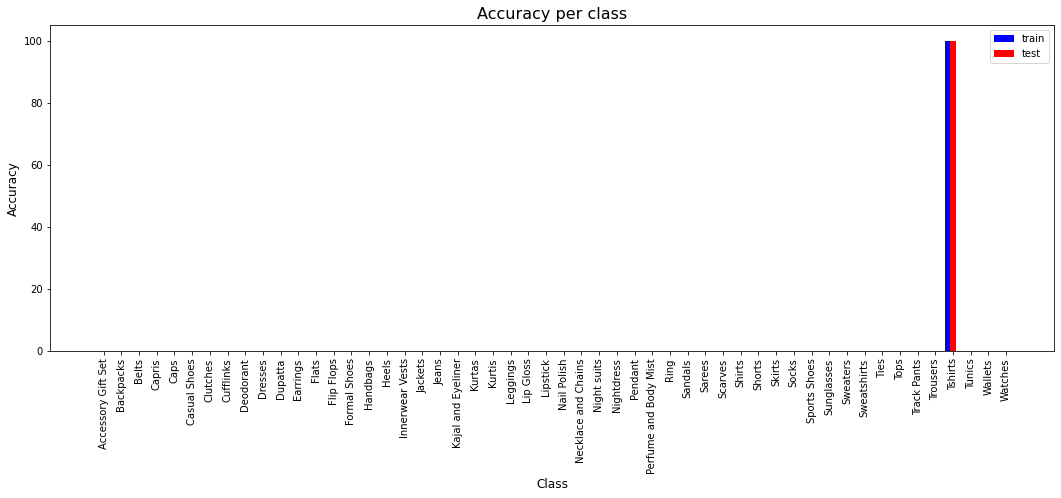

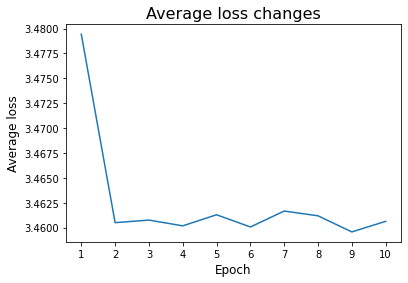

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr, mo = 0.98)

In [ ]:
optimal_momentum = 0.5

An epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. In other words, if we feed a neural network the training data for more than one epoch in different patterns, we hope for a better generalization when given a new unseen input. <br>
We increased the number of epochs from 10 to 20 and the accuracy increased remarkably. But there is no guarantee that a network will get better by letting it learn the data for very high number of epochs. We should stop training when the error rate is minimum. If we increase the number of epochs more than this, we will have an over-fitted model. So too many epochs may cause our model to over-fit the training data.

epoch 1, train_loss: 2.538, time elapsed: 15.809595 seconds
epoch 2, train_loss: 1.739, time elapsed: 15.844803 seconds
epoch 3, train_loss: 1.450, time elapsed: 15.882857 seconds
epoch 4, train_loss: 1.297, time elapsed: 15.838 seconds
epoch 5, train_loss: 1.199, time elapsed: 15.982536 seconds
epoch 6, train_loss: 1.119, time elapsed: 15.906812 seconds
epoch 7, train_loss: 1.048, time elapsed: 15.849535 seconds
epoch 8, train_loss: 0.998, time elapsed: 15.984323 seconds
epoch 9, train_loss: 0.952, time elapsed: 15.898231 seconds
epoch 10, train_loss: 0.917, time elapsed: 15.843406 seconds
epoch 11, train_loss: 0.885, time elapsed: 15.817194 seconds
epoch 12, train_loss: 0.849, time elapsed: 15.824397 seconds
epoch 13, train_loss: 0.835, time elapsed: 15.890081 seconds
epoch 14, train_loss: 0.805, time elapsed: 15.82901 seconds
epoch 15, train_loss: 0.778, time elapsed: 15.881563 seconds
epoch 16, train_loss: 0.757, time elapsed: 15.840723 seconds
epoch 17, train_loss: 0.744, time ela

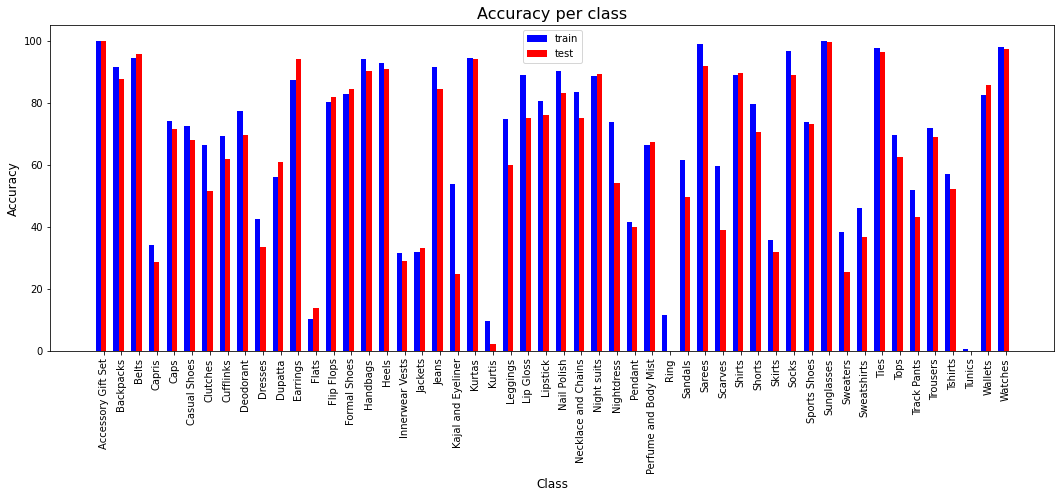

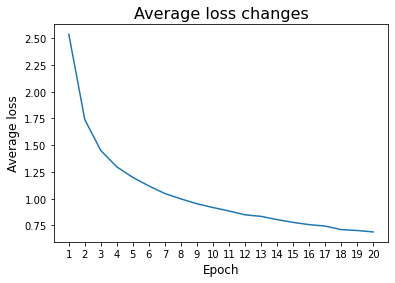

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, epochs = 20)

epoch 1, train_loss: 2.536, time elapsed: 15.932264 seconds
epoch 2, train_loss: 1.761, time elapsed: 15.9062 seconds
epoch 3, train_loss: 1.476, time elapsed: 15.861572 seconds
epoch 4, train_loss: 1.329, time elapsed: 16.02786 seconds
epoch 5, train_loss: 1.215, time elapsed: 15.973423 seconds
epoch 6, train_loss: 1.147, time elapsed: 15.905831 seconds
epoch 7, train_loss: 1.075, time elapsed: 15.888891 seconds
epoch 8, train_loss: 1.017, time elapsed: 15.868451 seconds
epoch 9, train_loss: 0.975, time elapsed: 15.942625 seconds
epoch 10, train_loss: 0.926, time elapsed: 15.871995 seconds
epoch 11, train_loss: 0.899, time elapsed: 15.909743 seconds
epoch 12, train_loss: 0.867, time elapsed: 15.94489 seconds
epoch 13, train_loss: 0.835, time elapsed: 15.891912 seconds
epoch 14, train_loss: 0.815, time elapsed: 15.905895 seconds
epoch 15, train_loss: 0.794, time elapsed: 15.895757 seconds
epoch 16, train_loss: 0.761, time elapsed: 15.940402 seconds
epoch 17, train_loss: 0.741, time ela

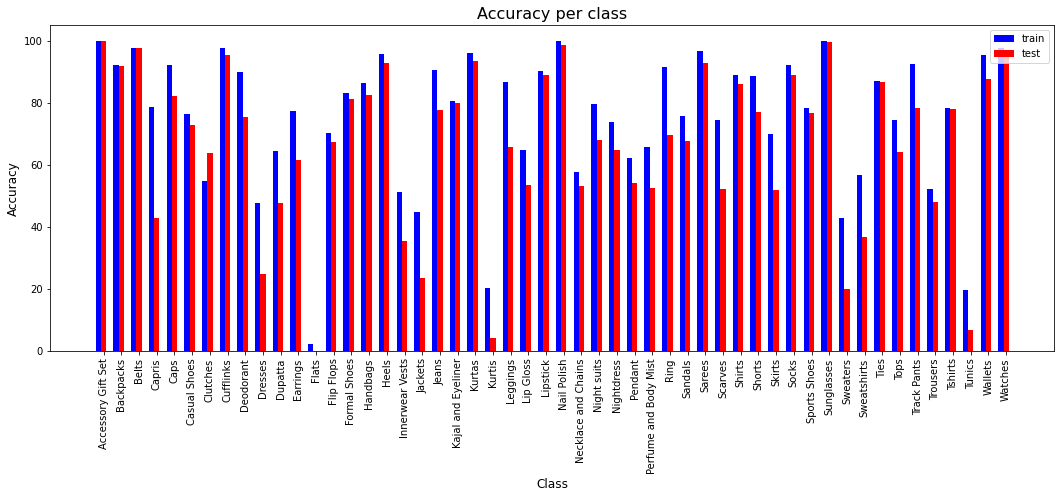

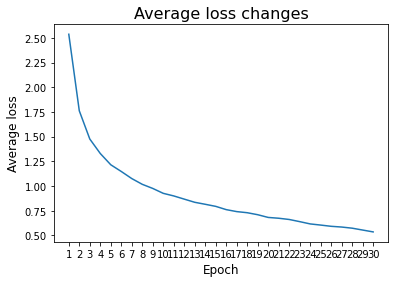

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, epochs = 30)

The following results show that tanh leads to less accuracy than ReLU. Generally, ReLU trains faster than tanh and obtains better accuracy.

epoch 1, train_loss: 2.113, time elapsed: 15.960147 seconds
epoch 2, train_loss: 1.424, time elapsed: 15.920032 seconds
epoch 3, train_loss: 1.263, time elapsed: 15.9436 seconds
epoch 4, train_loss: 1.158, time elapsed: 15.865269 seconds
epoch 5, train_loss: 1.095, time elapsed: 15.880137 seconds
epoch 6, train_loss: 1.037, time elapsed: 15.999824 seconds
epoch 7, train_loss: 0.995, time elapsed: 15.892415 seconds
epoch 8, train_loss: 0.950, time elapsed: 15.85719 seconds
epoch 9, train_loss: 0.922, time elapsed: 16.01248 seconds
epoch 10, train_loss: 0.884, time elapsed: 15.970485 seconds
total training time: 2.655 minutes
-------------------------------------------------------------
Train data:
Accuracy: 67.53521126760563%
Test data:
Accuracy: 66.5903890160183%
-------------------------------------------------------------


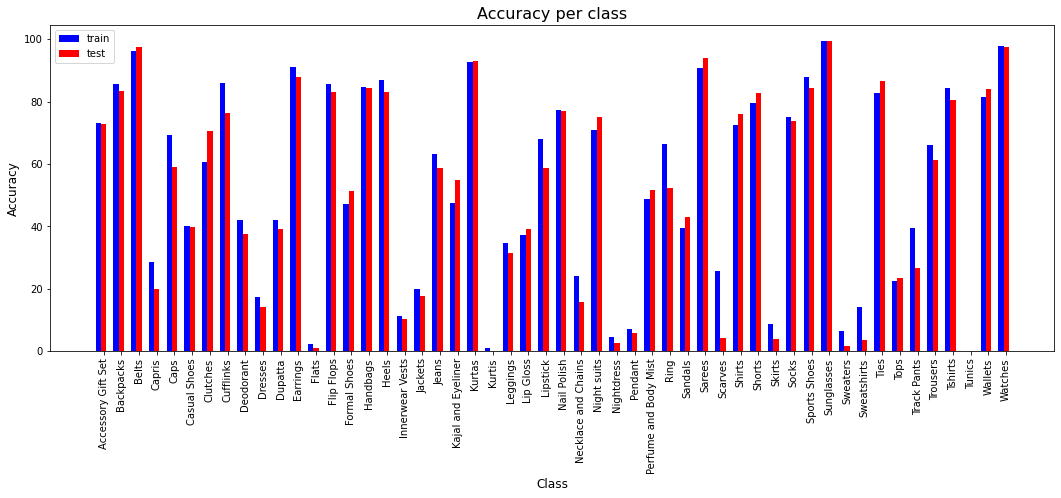

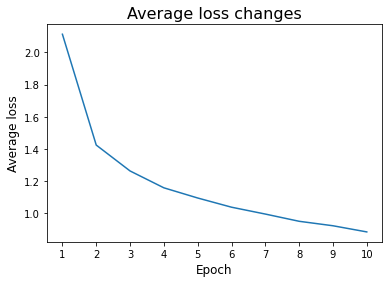

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, activation_func = torch.tanh)

The ReLU function gives an output x if x is positive and 0 otherwise. Because of the horizontal line in ReLU (for negative x), the gradient can go towards 0. For activations in that region of ReLU, the gradient will be 0 because of which the weights will not get adjusted. That means those neurons which go into that state will stop responding to variations in error or input. This is called dying ReLU problem. This problem can cause several neurons to just die and not respond, making a substantial part of the network passive. <i>--Medium</i> <br>
Leaky ReLU can fix the dying ReLU problem. Instead of the function being zero when x < 0, a leaky ReLU will instead have a small negative slope. As we can see in the results below, using leaky ReLU may lead to higher accuracy but the results are not always consistent.

epoch 1, train_loss: 2.605, time elapsed: 15.934834 seconds
epoch 2, train_loss: 1.856, time elapsed: 15.965096 seconds
epoch 3, train_loss: 1.520, time elapsed: 15.970779 seconds
epoch 4, train_loss: 1.351, time elapsed: 15.937418 seconds
epoch 5, train_loss: 1.242, time elapsed: 15.917831 seconds
epoch 6, train_loss: 1.171, time elapsed: 15.937653 seconds
epoch 7, train_loss: 1.097, time elapsed: 15.920463 seconds
epoch 8, train_loss: 1.038, time elapsed: 15.871572 seconds
epoch 9, train_loss: 0.994, time elapsed: 16.012344 seconds
epoch 10, train_loss: 0.948, time elapsed: 16.042128 seconds
total training time: 2.659 minutes
-------------------------------------------------------------
Train data:
Accuracy: 71.09322602280349%
Test data:
Accuracy: 69.06716920177682%
-------------------------------------------------------------


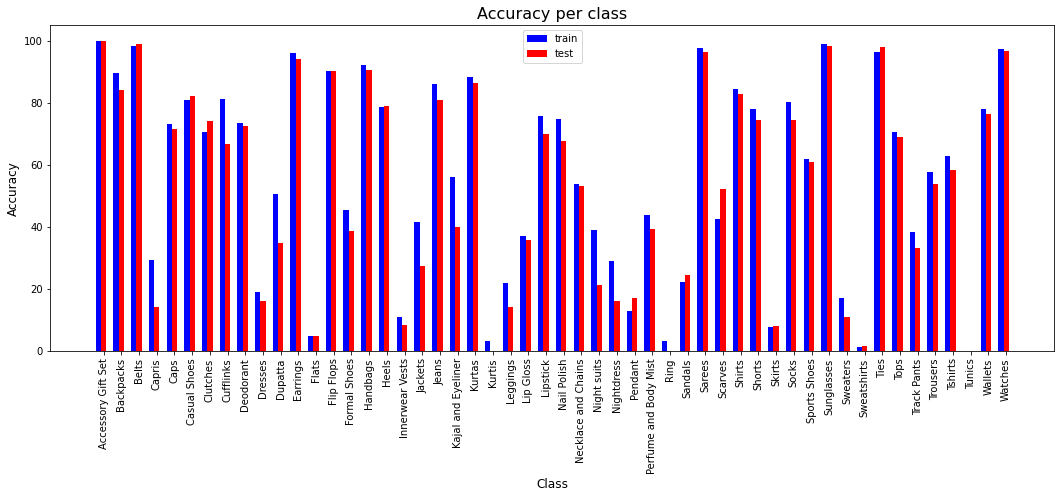

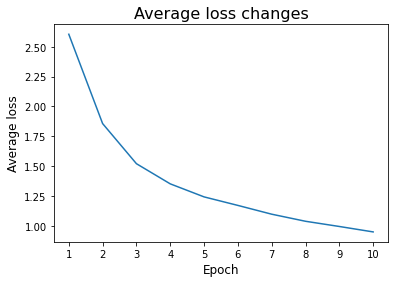

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, activation_func = F.leaky_relu_)

Techniques that seek to reduce overfitting by keeping network weights small are referred to as regularization methods. They avoid overfitting by penalizing the loss function. By adding a regularization term to the loss function, we keep the weights small and make the model simpler and avoid overfitting. Regularization has different types, such as L1, L2, ... .

It’s correct to say that neural network L2 regularization and weight decay are the same thing, but actually they do the same thing in slightly different ways. <br>
L2 regularization prevents weight values from getting large in magnitude by theoretically adding a term to the underlying loss function. The term penalizes weight values. <br>
If we simply decrease the value of each weight on each training iteration, we get an improved trained model that isn’t as likely to be overfitted. In this method the weight is updated as usual and then multiplied by a factor between 0 and 1 which reduces its value on each iteration. This technique is called weight decay. So weight decay also reduces the magnitudes of neural network weights during training like adding a regularization term to loss function.

In this part we set weight decay parameter to 0.1. We see that the accuracy decreases and the model is not trained well, because the weight decay is too large while the model was not even overfitted. <br>
If we set weight decay to 0.01, the accuracy still decreases because the model was not overfitted, but it's better than setting it to 0.1 since 0.01 is smaller and has less effect on the weights magnitude. 

epoch 1, train_loss: 3.466, time elapsed: 17.531751 seconds
epoch 2, train_loss: 3.386, time elapsed: 17.462392 seconds
epoch 3, train_loss: 3.376, time elapsed: 17.21957 seconds
epoch 4, train_loss: 3.380, time elapsed: 17.23498 seconds
epoch 5, train_loss: 3.387, time elapsed: 17.254521 seconds
epoch 6, train_loss: 3.379, time elapsed: 17.288253 seconds
epoch 7, train_loss: 3.372, time elapsed: 17.241501 seconds
epoch 8, train_loss: 3.379, time elapsed: 17.211746 seconds
epoch 9, train_loss: 3.372, time elapsed: 17.185072 seconds
epoch 10, train_loss: 3.378, time elapsed: 17.309456 seconds
total training time: 2.882 minutes
-------------------------------------------------------------
Train data:
Accuracy: 9.19852448021462%
Test data:
Accuracy: 9.234082649077937%
-------------------------------------------------------------


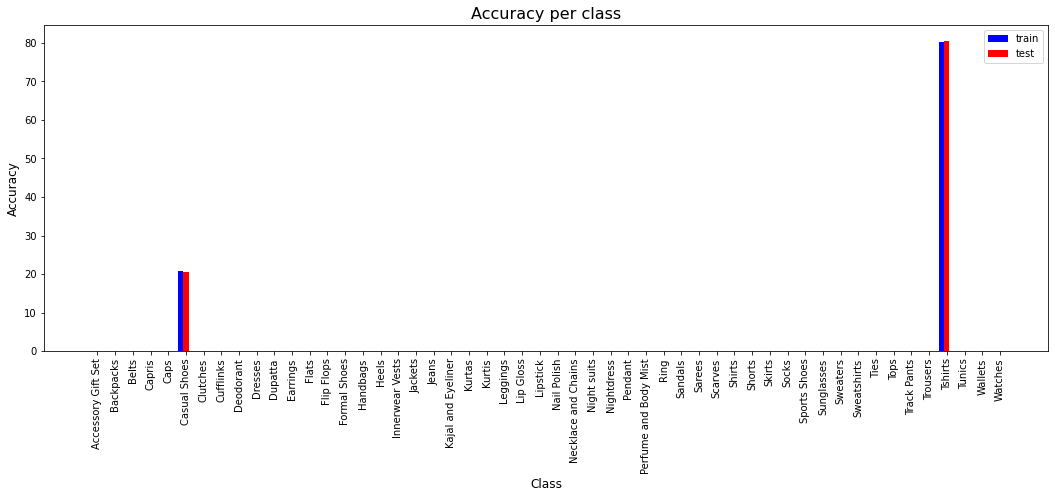

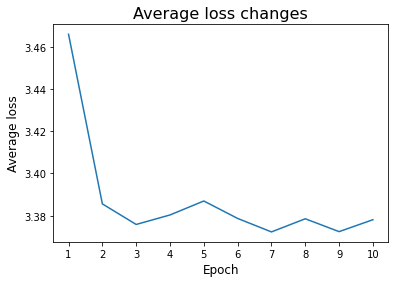

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, wd = 0.1)

epoch 1, train_loss: 2.691, time elapsed: 17.347008 seconds
epoch 2, train_loss: 2.190, time elapsed: 17.308937 seconds
epoch 3, train_loss: 1.956, time elapsed: 17.286514 seconds
epoch 4, train_loss: 1.855, time elapsed: 17.274486 seconds
epoch 5, train_loss: 1.824, time elapsed: 17.407858 seconds
epoch 6, train_loss: 1.800, time elapsed: 17.389564 seconds
epoch 7, train_loss: 1.804, time elapsed: 17.386852 seconds
epoch 8, train_loss: 1.772, time elapsed: 17.25992 seconds
epoch 9, train_loss: 1.780, time elapsed: 17.342431 seconds
epoch 10, train_loss: 1.804, time elapsed: 17.376533 seconds
total training time: 2.890 minutes
-------------------------------------------------------------
Train data:
Accuracy: 43.57142857142857%
Test data:
Accuracy: 43.65325077399381%
-------------------------------------------------------------


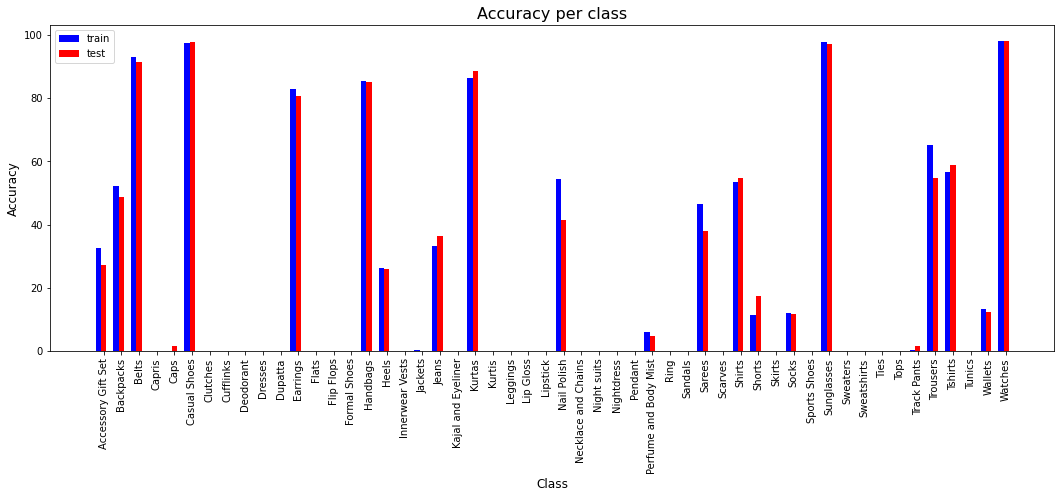

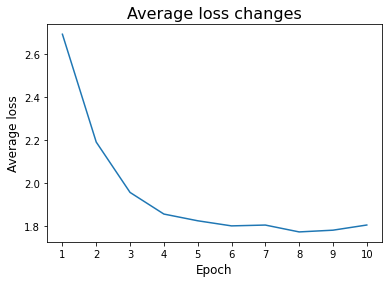

In [ ]:
run_network(selected_transform = transforms.ToTensor, learning_rate = optimal_lr,
            mo = optimal_momentum, wd = 0.01)